In [1]:
# Essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from datetime import datetime
import random
from tqdm import tqdm_notebook as tqdm
from PIL import Image
# Sklearn
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
# Torch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# TorchVision
from torchvision import models, transforms, datasets
from torchvision.utils import make_grid

device = torch.device('cuda')

# EDA

In [2]:
df_train = pd.read_csv('../input/3md3070-dlmi/trainset/trainset_true.csv')
df_train['GENDER'] = df_train.GENDER.apply(lambda x: int(x=='F'))
df_train['DOB'] = df_train['DOB'].apply(lambda x: x.replace("-", "/"))
df_train['AGE'] = df_train['DOB'].apply(lambda x: 2020-int(x.split("/")[-1]))
df_train.head()

,ID,LABEL,GENDER,DOB,LYMPH_COUNT,AGE
0,P26,1,0,11/3/1933,11.2,87
1,P183,1,0,5/15/1942,12.8,78
2,P89,1,0,6/19/1935,9.6,85
3,P123,1,0,1/27/1931,122.6,89
4,P61,1,1,3/5/1931,11.6,89


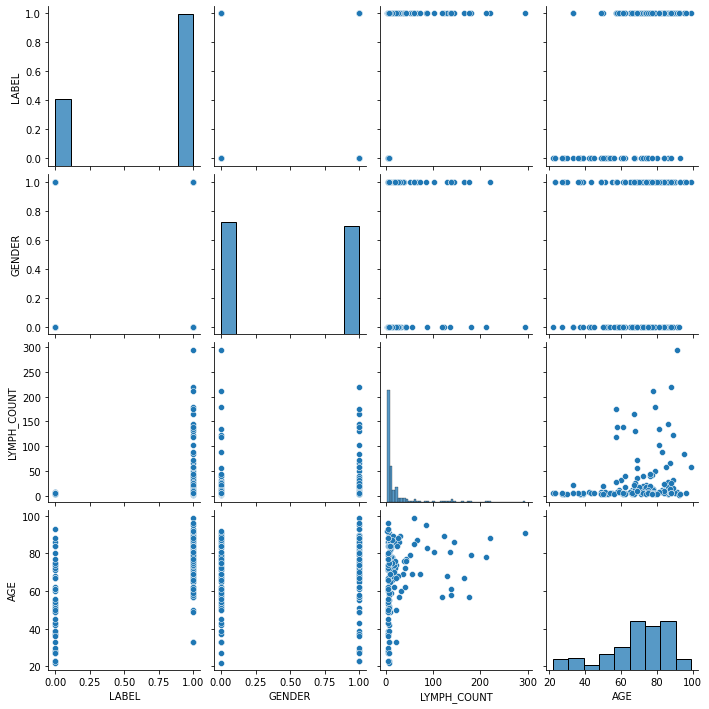

In [3]:
sns.pairplot(df_train[['LABEL', 'GENDER', 'LYMPH_COUNT', "AGE"]])

In [4]:
df_test = pd.read_csv('../input/3md3070-dlmi/testset/testset_data.csv')
df_test.head()

,ID,LABEL,GENDER,DOB,LYMPH_COUNT
0,P71,-1,M,1/17/1946,5.76
1,P16,-1,M,3/5/1940,32.00
2,P114,-1,M,6/16/1929,4.60
3,P170,-1,M,11/3/1933,4.80
4,P98,-1,F,5/14/1970,6.24


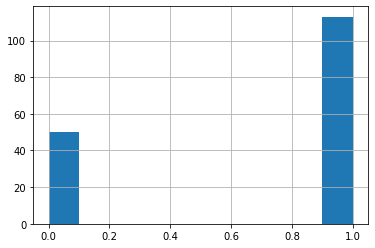

In [5]:
df_train.LABEL.hist()
plt.show()

In [6]:
def show_sample(group, shape=(5,2), figsize=(15,15)):
    total_samples = shape[0]*shape[1]
    nrow = shape[0]
    
    path_samples = random.sample(os.listdir(f'../input/3md3070-dlmi/trainset/{group}'),total_samples)
    batch_tensor = []
    for path in path_samples:
        img = transforms.ToTensor()(Image.open(os.path.join(f'../input/3md3070-dlmi/trainset/{group}', path)).convert("RGB")).unsqueeze(0)
        batch_tensor.append(img)
    batch_tensor = torch.cat(batch_tensor)
    grid_img = make_grid(batch_tensor, nrow=nrow)
    plt.figure(figsize=figsize)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

Showing 10 samples from P0


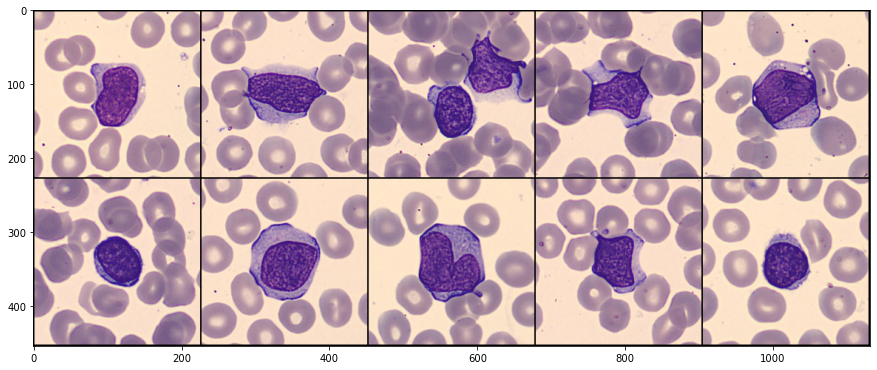

In [7]:
print("Showing 10 samples from P0")
show_sample("P0")

# Baselines
### Random Predictor
In this section we evaluate a random predictor on the training set

In [8]:
random.seed(42)
y_pred_random = []
for i in range(len(df_train)):
    y_pred_random.append(random.choice([0,1]))
print("Random predictor got", balanced_accuracy_score(df_train.LABEL, y_pred_random))

Random predictor got 0.4346902654867256


### Dummy Predictor

In this section we evaluate the performance of a dummy predictor that only outputs the most frequent label, 1 in this case on the training set.

In [9]:
y_pred_dummy = []
for i in range(len(df_train)):
    y_pred_dummy.append(1)
print("Dummy predictor got", balanced_accuracy_score(df_train.LABEL, y_pred_dummy))

Dummy predictor got 0.5


### LYMPH_COUNT Predictor
By looking at the dataset, we can see there's some correlation between the LYMPH_COUNT and the label. More specifically, the average value of the LYMPH_COUNT for 0 LABEL is 5 and for 1 is 35, so we'll empirically assign 0 to any bag with LYMPH_COUNT<=some_value and 1 otherwise

In [10]:
stratfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
split_scores = []
for train_index, test_index in stratfold.split(df_train, df_train.LABEL):
    X_train, X_val = df_train.LYMPH_COUNT[train_index].values.reshape(-1, 1), df_train.LYMPH_COUNT[test_index].values.reshape(-1, 1)
    y_train, y_val = df_train.LABEL[train_index], df_train.LABEL[test_index]
    y_pred = [int(x>7) for x in X_val]
    print("Balanced Accuracy Score", balanced_accuracy_score(y_val, y_pred))
    split_scores.append(balanced_accuracy_score(y_val, y_pred))
print("Mean Balanced Accuracy", np.mean(split_scores))

Balanced Accuracy Score 0.8195652173913044
Balanced Accuracy Score 0.8195652173913044
Balanced Accuracy Score 0.8478260869565217
Balanced Accuracy Score 0.8409090909090908
Balanced Accuracy Score 0.9318181818181819
Mean Balanced Accuracy 0.8519367588932806


Let's make a first submission with this baseline, we can probably get more just by making a linear regression, but let's try this simple approach first!

In [11]:
sub_dict = {"ID":df_test.ID.values, "Predicted": [int(df_test.iloc[i,4]>7) for i in range(len(df_test))]}
df_sub = pd.DataFrame.from_dict(sub_dict)
df_sub.to_csv('submission.csv')

This approach yields a score of 0.82337 on the public LB.

### Logistic Regression
Since the last approach seemed to work, let's try to apply a logistic regression on the LYMPH COUNT variable and AGE.

In [12]:
stratfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
split_scores = []
for train_index, test_index in stratfold.split(df_train, df_train.LABEL):
    X_train, X_val = df_train[["LYMPH_COUNT", "AGE"]].values[train_index], df_train[["LYMPH_COUNT", "AGE"]].values[test_index]
    y_train, y_val = df_train.LABEL[train_index], df_train.LABEL[test_index]
    clf = LogisticRegression(random_state=42).fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print("Balanced Accuracy Score", balanced_accuracy_score(y_val, y_pred))
    split_scores.append(balanced_accuracy_score(y_val, y_pred))
print("Mean Balanced Accuracy", np.mean(split_scores))

Balanced Accuracy Score 0.9130434782608696
Balanced Accuracy Score 0.7
Balanced Accuracy Score 0.8130434782608695
Balanced Accuracy Score 0.8545454545454545
Balanced Accuracy Score 0.8545454545454545
Mean Balanced Accuracy 0.8270355731225296


### RandomForestClassifier

The logistic regression doesn't seem to be suitable in this setting, let's try a more robust estimator: Random Forest

In [13]:
stratfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
split_scores = []
for train_index, test_index in stratfold.split(df_train, df_train.LABEL):
    X_train, X_val = df_train[["LYMPH_COUNT", "AGE"]].values[train_index], df_train[["LYMPH_COUNT", "AGE"]].values[test_index]
    y_train, y_val = df_train.LABEL[train_index], df_train.LABEL[test_index]
    clf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print("Balanced Accuracy Score", balanced_accuracy_score(y_val, y_pred))
    split_scores.append(balanced_accuracy_score(y_val, y_pred))
print("Mean Balanced Accuracy", np.mean(split_scores))

Balanced Accuracy Score 0.8847826086956522
Balanced Accuracy Score 0.7282608695652174
Balanced Accuracy Score 0.841304347826087
Balanced Accuracy Score 0.8363636363636364
Balanced Accuracy Score 0.8772727272727273
Mean Balanced Accuracy 0.8335968379446641


# DataLoading

In [27]:
class LymphBags(torch.utils.data.Dataset):
    def __init__(self, bags_dir, df, mode='train', transforms=None):
        assert mode in ['train', 'test'], "mode must belong to ['train', 'test']"
        self.transforms = transforms
        self.mode = mode
        self.df = df
        self.dir = bags_dir
        self.bags = list(filter(lambda x: x[0] == 'P', os.listdir(bags_dir)))

    def __len__(self):
        return len(self.bags)
        
    def __getitem__(self, index):
        if self.mode == 'train':
            bags = os.path.join(self.dir, self.bags[index])
            images = []
            for bag in os.listdir(bags):
                img = Image.open(os.path.join(bags, bag))
                if self.transforms:
                    img = self.transforms(img).unsqueeze(0)
                images.append(img)
            images = torch.cat(images)
            idx_ = self.df[self.df['ID'] == self.bags[index]].index[0]
            label = self.df.iloc[idx_, 1]
            return images, label
        else:
            bags = os.path.join(self.dir, self.bags[index])
            images = []
            for bag in os.listdir(bags):
                img = Image.open(os.path.join(bags, bag))
                if self.transforms:
                    img = self.transforms(img).unsqueeze(0)
                images.append(img)
            images = torch.cat(images)
            return images

        


# CNN Baseline

We will be using a model from the paper ["Attention-based Deep Multiple Instance Learning"](https://arxiv.org/pdf/1802.04712v4.pdf)

In [28]:
class Attention(nn.Module):
    def __init__(self, head, L=500, D=128, K=1):
        super(Attention, self).__init__()
        self.L = L
        self.D = D
        self.K = K

        self.feature_extractor = head

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(0)

        H = self.feature_extractor(x) # NxL
        H = H.view(-1, 512)
        A = self.attention(H)  # NxK
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim=1)  # softmax over N

        M = torch.mm(A, H)  # KxL

        Y_prob = self.classifier(M)
        Y_hat = torch.ge(Y_prob, 0.5).float()

        return Y_prob, Y_hat, A

    # AUXILIARY METHODS
    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        _, Y_hat, _ = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().item()

        return error, Y_hat

    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))  # negative log bernoulli

        return neg_log_likelihood, A

Here we define the training function:

In [29]:
def train(epoch):
    model.train()
    train_loss = 0.
    train_error = 0.
    for batch_idx, (data, label) in enumerate(tqdm(train_loader)):
        bag_label = label[0]
        data, bag_label = data.to(device), bag_label.to(device)
        # reset gradients
        optimizer.zero_grad()
        # calculate loss and metrics
        loss, _ = model.calculate_objective(data, bag_label)
        train_loss += loss.data[0]
        error, _ = model.calculate_classification_error(data, bag_label)
        train_error += error
        # backward pass
        loss.backward()
        # step
        optimizer.step()

    # calculate loss and error for epoch
    train_loss /= len(train_loader)
    train_error /= len(train_loader)

    print('Epoch: {}, Loss: {:.4f}, Train error: {:.4f}'.format(epoch, train_loss.cpu().numpy()[0], train_error))

In [33]:
train_dir = '../input/3md3070-dlmi/trainset'
test_dir = '../input/3md3070-dlmi/testset'
# Data Augmentation
tsfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])
trainset = LymphBags(train_dir, df_train, transforms=tsfms)
testset = LymphBags(test_dir, df_test, transforms=tsfms)

train_loader = DataLoader(trainset,batch_size=1, shuffle=True)

In [34]:
# Define feature extractor
feat_extractor = models.resnet34(pretrained=True).to(device)
feat_extractor = torch.nn.Sequential(*(list(feat_extractor.children())[:-1]))
# Define model
model = Attention(head=feat_extractor, L=512)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-5)

In [ ]:
for epoch in range(20):
    train(epoch)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.7366, Train error: 0.3436


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.6508, Train error: 0.3313


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.6218, Train error: 0.3374


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.6377, Train error: 0.3067


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.6178, Train error: 0.3067


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.6085, Train error: 0.2945


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.6346, Train error: 0.3129


  0%|          | 0/163 [00:00<?, ?it/s]